# Infobae

En esta notebook veremos qué se puede hacer con los artículos de infobae...

In [2]:
%load_ext autoreload
%autoreload 2
from mongoengine import connect
from tweepyrate import create_apps
from hatespeech_models import Tweet, Article

client = connect("hatespeech-news")
db = client["hatespeech-news"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import json
with open("../../config/query_2.0.json") as f:
    query = json.load(f) 

query

{'users': ['LANACION', 'clarincom', 'cronica', 'infobae', 'perfilcom'],
 'min_date': '2020-02-10T00:00:00Z',
 'search_terms': ['coronavirus',
  'covid',
  'cuarentena',
  'normalidad',
  'aislamiento ',
  'padecimiento',
  'encierro',
  'fase',
  'infectados',
  'Wuhan',
  'distanciamiento',
  'fiebre',
  'síntomas',
  'dengue',
  'aedes',
  'mosquito',
  'cacharro']}

In [6]:
import datetime

min_date = datetime.datetime.strptime(query["min_date"], "%Y-%m-%dT%H:%M:%SZ")
text_query = " ".join(query["search_terms"])

articles = Article.objects(
    user="infobae",
    created_at__gte=min_date
).search_text(text_query)

articles.count()

8639

/home/jmperez/.local/share/virtualenvs/hatespeech-collection-qaK7Gomm/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


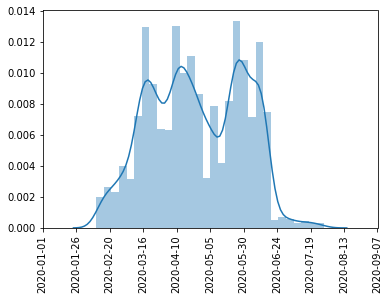

In [7]:
from hate_collector.plot import distplot_dates

dates = [art["created_at"] for art in articles]

distplot_dates(dates)

Ok! Tenemos un problema a partir del ... 20 de Junio?

In [8]:
missing_articles = Tweet.objects(
    user_name="infobae", 
    in_reply_to_status_id=None,
    retweeted_status=None,
    created_at__gte=datetime.datetime(2020, 6, 24)
).as_pymongo()

In [9]:
tweet = missing_articles[0]


news_url = tweet["entities"]["urls"][0]["expanded_url"]
user_name = tweet["user_name"]


tweet["text"]

'Conmovedora propuesta de casamiento de un joven italiano en el lecho de muerte de su novia https://t.co/sPVzoSwr8Z'

In [10]:
news_url

'https://www.infobae.com/america/mundo/2020/06/23/la-conmovedora-propuesta-de-casamiento-de-un-joven-italiano-en-el-lecho-de-muerte-de-su-novia/?utm_medium=Echobox&utm_source=Twitter#Echobox=1592938640'

In [14]:
Article.objects(user="infobae")[0]

832174434853146624 - infobae
Sergio Massa: "Le exigimos al Presidente la derogación del decreto que rebaja las jubilaciones"

(2 comentarios)
Tweet:
Massa: "Exigimos que el Presidente derogue el decreto que rebaja las jubilaciones" https://t.co/NpP34CsmhO https://t.co/r6vR2hVTv5
    

In [11]:
import newspaper as ns

article = ns.Article(news_url)
article.download()
article.parse()

In [37]:
from hate_collector.article import body_getters

if article.doc.cssselect("pija"):
    1
else:
    print(-1)

-1


In [34]:
from hate_collector.article import download_article

download_article(missing_articles[0])

In [ ]:
for art in articles.limit(30):
    print("="*80 +'\n\n')
    print(art.created_at, '\n\n')
    print(art.title, "\n\n")
    print(f"comentarios: {len(art['comments'])}")
    print(art.url, "\n\n")
    print(":"*30, '\n\n')
    print(art.body)

In [55]:
from newspaper import Article as NSArticle
url = "https://www.infobae.com/politica/2020/07/31/jose-maria-campagnoli-que-este-beraldi-en-la-comision-es-un-mensaje-para-los-jueces-que-juzgan-a-cristina-kirchner/"
article = NSArticle(url, language="es")

article.download()
article.parse()

In [53]:
print(article.text)

El fiscal José María Campagnoli (NA)

El fiscal de distrito de Saavedra, José María Campagnoli, está en contra de la reforma judicial que esta semana presentó el gobierno de Alberto Fernández. “ Es un despilfarro de dinero en este contexto de miseria porque estamos en la peor crisis económica del país ”, dijo en diálogo con Infobae. Recordó el proyecto que había elaborado en los primeros años del gobierno de Néstor Kirchner cuando era funcionario del Ministerio de Justicia cuando al frente estaba Gustavo Béliz.

“Iban a haber unos 80 juzgados de primera instancia del crimen organizado y se ampliaba la competencia que llegaba hasta la ciudad de Rosario y el conurbano bonaerense, que es el corredor donde se cometen la mayor cantidad de delitos organizados. Eso era a costo cero no esta elefantística reforma que tiene previsto el nombramiento de más de 200 jueces”, recordó sobre esa iniciativa.

También opinó que la Corte debe tener cinco integrantes, que no se debe dividir en salas y que 

In [54]:
elem = article.doc.cssselect("article")[0]

children = list(elem.getchildren())


text_children = [c for c in children if c.tag == "p"]

text = "\n\n".join(t.text_content().strip() for t in text_children)

print(text)

El fiscal de distrito de Saavedra, José María Campagnoli, está en contra de la reforma judicial que esta semana presentó el gobierno de Alberto Fernández. “Es un despilfarro de dinero en este contexto de miseria porque estamos en la peor crisis económica del país”, dijo en diálogo con Infobae. Recordó el proyecto que había elaborado en los primeros años del gobierno de Néstor Kirchner cuando era funcionario del Ministerio de Justicia cuando al frente estaba Gustavo Béliz.

“Iban a haber unos 80 juzgados de primera instancia del crimen organizado y se ampliaba la competencia que llegaba hasta la ciudad de Rosario y el conurbano bonaerense, que es el corredor donde se cometen la mayor cantidad de delitos organizados. Eso era a costo cero no esta elefantística reforma que tiene previsto el nombramiento de más de 200 jueces”, recordó sobre esa iniciativa.

También opinó que la Corte debe tener cinco integrantes, que no se debe dividir en salas y que sí se le deben estipular plazos para res

In [38]:
"""
NOTICIAS VIEJAS
"""
elem = article.doc.get_element_by_id("article-content")

"""
Esto es código particular de infobae
Saco los links que están al pie de la nota
"""
children = list(elem.getchildren())

last = children[-1]

while len(list(children[-1].iter("a"))) > 0:
    children.pop(-1)
    
"""
Me quedo con el texto
"""
text_children = [t for t in children if t.tag not in ["meta", "script"]]
text = "\n\n".join(t.text_content().strip() for t in text_children)

print(text.strip())

[autoreload of hate_collector.article failed: Traceback (most recent call last):
  File "/home/jmperez/.local/share/virtualenvs/hatespeech-collection-qaK7Gomm/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/jmperez/.local/share/virtualenvs/hatespeech-collection-qaK7Gomm/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/jmperez/.local/share/virtualenvs/hatespeech-collection-qaK7Gomm/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/home/jmperez/.local/share/virtualenvs/hatespeech-collection-qaK7Gomm/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, 

KeyError: 'article-content'

## Noticias repetidas